In [ ]:
%cd ../..
%pwd
from __future__ import annotations
import os, json, glob, re, math, random, itertools
from pathlib import Path
from collections import Counter, defaultdict

import torch
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/root/CoTFaithChecker


In [2]:
ANSWERS_DIR      = Path("e_confirm_xy_yx/outputs/matched_vals_gt")       # all *.json files
ACTIVATIONS_DIR  = Path("h_hidden_space/outputs/f1_hint_xyyx/xyyx_deterministic")
PROBE_SAVE_DIR   = Path("linear_probes"); PROBE_SAVE_DIR.mkdir(exist_ok=True)
RANDOM_SEED      = 0
torch.manual_seed(RANDOM_SEED); random.seed(RANDOM_SEED); np.random.seed(RANDOM_SEED)


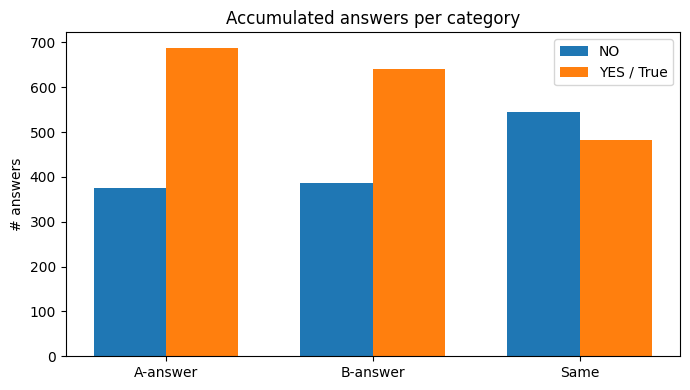

In [3]:
def iter_answer_files(answer_dir: Path):
    for fp in answer_dir.glob("*.json"):
        with open(fp) as f:
            yield json.load(f), fp.name

a_counter, b_counter, same_counter = Counter(), Counter(), Counter()

for data, name in iter_answer_files(ANSWERS_DIR):
    # if the file is a dict with key "questions", grab that list; otherwise assume it's already a list
    questions = data["questions"] if isinstance(data, dict) else data

    for q in questions:
        a_counter[q["a_answers"][0]]   += 1
        b_counter[q["b_answers"][0]]   += 1
        same_counter[q["same"][0]]     += 1

for k in ("YES", "NO"):        # for a_ / b_
    a_counter.setdefault(k, 0)
    b_counter.setdefault(k, 0)
for k in (True, False):        # for same_
    same_counter.setdefault(k, 0)

fig, ax = plt.subplots(figsize=(7, 4))
groups   = ["A-answer", "B-answer", "Same"]
yes_vals = [a_counter["YES"], b_counter["YES"], same_counter[True]]
no_vals  = [a_counter["NO"],  b_counter["NO"],  same_counter[False]]

x = np.arange(len(groups))
width = 0.35
ax.bar(x - width/2, no_vals, width, label="NO")
ax.bar(x + width/2, yes_vals, width, label="YES / True")
ax.set_xticks(x); ax.set_xticklabels(groups)
ax.set_ylabel("# answers")
ax.set_title("Accumulated answers per category")
ax.legend(); plt.tight_layout()


In [4]:
TOKENIZER_NAME = "huggyllama/llama-7b"
from transformers import AutoTokenizer
tok = AutoTokenizer.from_pretrained(TOKENIZER_NAME)
tok.pad_token = tok.eos_token  # safety

ANSWER_TOKEN_IDS = {t: tok.encode(t, add_special_tokens=False)[0] for t in ("YES", "NO")}
print(ANSWER_TOKEN_IDS)  # {'YES': 13023, 'NO': 19353}  (numbers depend on tokenizer)


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


{'YES': 22483, 'NO': 11698}


In [ ]:
import itertools, math
from pathlib import Path
from collections import defaultdict
import torch, re
from transformers import AutoModelForCausalLM

MODEL_PATH = "huggyllama/llama-7b"          # <-- edit to your checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

_base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_PATH, torch_dtype=torch.float32, low_cpu_mem_usage=True
).to(device).eval()

W = _base_model.lm_head.weight.detach().cpu()          # (vocab, hdim)
b = _base_model.lm_head.bias.detach().cpu() if _base_model.lm_head.bias is not None else None

yes_w = W[ANSWER_TOKEN_IDS["YES"]]                     # (hdim,)
no_w  = W[ANSWER_TOKEN_IDS["NO"]]
yes_b = b[ANSWER_TOKEN_IDS["YES"]] if b is not None else 0.0
no_b  = b[ANSWER_TOKEN_IDS["NO"]]  if b is not None else 0.0

def yes_no_from_hidden(h: torch.Tensor) -> str:
    """Return 'YES' or 'NO' by comparing lm-head scores."""
    yes_score = float(torch.dot(h, yes_w) + yes_b)
    no_score  = float(torch.dot(h,  no_w) + no_b)
    return "YES" if yes_score > no_score else "NO"

def hidden_files():
    return sorted(ACTIVATIONS_DIR.rglob("*_hidden.pt"))

layer_buckets: dict[int, list[tuple[torch.Tensor, int]]] = defaultdict(list)

for hid_path in hidden_files():
    expected = parse_expected_from_fname(hid_path.name)          # "YES" / "NO"
    batch_hidden: list[torch.Tensor] = torch.load(hid_path)      # list[n_layers] of (B,h)

    last_layer = batch_hidden[-1]                                # (B, h)
    preds = [yes_no_from_hidden(h.float()) for h in last_layer]  # len B list

    for L, layer_tensor in enumerate(batch_hidden):              # layer_tensor : (B, h)
        for h_vec, pred in zip(layer_tensor, preds):
            label = 1 if pred == expected else 0
            layer_buckets[L].append((h_vec.float(), label))

print(f"Collected activations:")
for L in sorted(layer_buckets)[:4]:
    print(f"  layer {L:2d}  →  {len(layer_buckets[L])} samples")


Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.86s/it]


NameError: name 'parse_expected_from_fname' is not defined